# Clustering Mobile Phones Into Clusters

**Data Link**

https://www.kaggle.com/iabhishekofficial/mobile-price-classification

This program tries to create clusters of mobile data available from above link.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings

# Temporarily ignore all warnings for this notebook session as they are creating noise
warnings.filterwarnings('ignore')

/Users/soumya/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


**Dependent Column/Variable/Feature**

Since we are trying to predict the price range of the mobile phone our dependent variable will be price_range column.

## Utility Functions
Following section contains utility functions that will be used for the application

In [2]:
def basic_dataframe_info_and_null_check(df: pd.DataFrame):
    """
    This function checks 
    - shape of a data frame, 
    - data types of columns,
    - presence of null value in any olumn of the dataframe
    
    Args:
        df (pd.DataFrame): The input DataFrame.
    """
    rows, columns = df.shape
    print("Number of columns in train data :", columns)
    print("Number of rows in train data :", rows)

    # Check data types
    print("\n\ndata Type of All Attributes")
    print(df.info())

    # Check if there is any missing data
    print("\n\nMissing values in each column")
    print(df.isnull().sum())

In [3]:
def check_min_max(df: pd.DataFrame):
    """
    This function checks the min and max values of each column in a data frame
    
    Args:
        df (pd.DataFrame): The input DataFrame.
    """
    # Find the minimum value for every column
    min_values = df.min()
    print("Minimum Values:\n", min_values)

    # Find the maximum value for every column
    max_values = df.max()
    print("\nMaximum Values:\n", max_values)

In [4]:
def drop_columns_from_df(df: pd.DataFrame, fields_to_drop: list) -> pd.DataFrame:
    """
    This function takes a list of fileds to be dropped from a data frame and returns a new dataframe without
    listed columns.
    
    Args:
        df (pd.DataFrame): The input DataFrame.
        fields_to_drop (list): A list of column names (strings) to be dropped.

    Returns:
        pd.DataFrame: A new DataFrame with the specified columns removed.    
    """
    existing_fields = [col for col in fields_to_drop if col in df.columns]
    df_trimmed = df.drop(columns=existing_fields, axis=1)
    return df_trimmed

**Scaling function**

Scaling function. This function scales a list of columns/fields and then adds them as additional fields 
to a new dataframe and returns it. We are using min_max_scaling here.

In [5]:
def min_max_scale_columns(df: pd.DataFrame, fields_for_scaling: list) -> pd.DataFrame:
    """
    Applies Min-Max Scaling (Normalization) to a list of specified columns 
    in a Pandas DataFrame.
    
    The resulting scaled values will range from 0 to 1.

    Args:
        df (pd.DataFrame): The input DataFrame.
        columns_to_scale (list): A list of column names (strings) 
                                 to apply scaling to.

    Returns:
        pd.DataFrame: A new DataFrame with the specified columns scaled.
    """
    # Create a copy to avoid modifying the original DataFrame
    df_scaled = df.copy()
    
    for col in fields_for_scaling:
        if col not in df.columns:
            print(f"Warning: Column '{col}' not found in DataFrame. Skipping.")
            continue
            
        # Calculate min and max for the specific column
        col_min = df_scaled[col].min()
        col_max = df_scaled[col].max()
        
        # Check for division by zero (e.g., if max == min)
        if (col_max - col_min) == 0:
            print(f"Warning: Column '{col}' has zero range (min=max). Values set to 0.")
            df_scaled[col+'_scaled'] = 0.0
        else:
            # Apply the Min-Max formula
            df_scaled[col+'_scaled'] = (df_scaled[col] - col_min) / (col_max - col_min)
            
    return df_scaled

## EDA and Data Enrichment
Following section analyzes the data and based on that we apply transformation to enrich the data and make it ready 
for machine learning.

In [6]:
# Read the data from the file
df = pd.read_csv("./train.csv")
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [7]:
# Check number of rows, columns, data types and null values in the training dataframe
basic_dataframe_info_and_null_check(df)

Number of columns in train data : 21
Number of rows in train data : 2000


data Type of All Attributes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64 

**Analysis**

There are 21 columns in the dataset and a total of 2000 rows.
There is no record or column with missing data. So we don't need to populate any data element to account for missing data.

**Scaling and Weight Manipulation**

Now we are going to check min and max value. Since we are going to do a numerical analysis here 
we need to make sure each column or attribute has comparable range. In order to do that we need to scale them
to restrict their values between 0 and 1.
Also data types of all fields is numeric(from above output), so we don't need to have weight manipulation here,
since there is no finite set of categorical attribute.


In [8]:
# Find the minimum and maximum value for every column
check_min_max(df)

Minimum Values:
 battery_power    501.0
blue               0.0
clock_speed        0.5
dual_sim           0.0
fc                 0.0
four_g             0.0
int_memory         2.0
m_dep              0.1
mobile_wt         80.0
n_cores            1.0
pc                 0.0
px_height          0.0
px_width         500.0
ram              256.0
sc_h               5.0
sc_w               0.0
talk_time          2.0
three_g            0.0
touch_screen       0.0
wifi               0.0
price_range        0.0
dtype: float64

Maximum Values:
 battery_power    1998.0
blue                1.0
clock_speed         3.0
dual_sim            1.0
fc                 19.0
four_g              1.0
int_memory         64.0
m_dep               1.0
mobile_wt         200.0
n_cores             8.0
pc                 20.0
px_height        1960.0
px_width         1998.0
ram              3998.0
sc_h               19.0
sc_w               18.0
talk_time          20.0
three_g             1.0
touch_screen        1.0
wifi       

**Note**

Following attributes denote more like true false than 0 and 1.

1. blue(has_bluetooth)

2. dual_sim(yes/no)

3. four_g(Has_4g_max_compatibility)

4. three_g(Has_3g_max_compatibility)

5. touch_screen(Has_touch_screen)

6. wifi(Has_wifi)

Since these have just two possible values and 0 represents absence than missing data there is no need to do weight manipulation here. If we had more than 2 possible values we might have done weight manipulation as well.


In [9]:
fields_for_scaling=[
    'battery_power',
    'clock_speed',
    'fc',
    'int_memory',
    'm_dep',
    'mobile_wt',
    'n_cores',
    'pc',
    'px_height',
    'px_width',
    'ram',
    'sc_h',
    'sc_w',
    'talk_time']
print(fields_for_scaling)

scaled_df = min_max_scale_columns(df,fields_for_scaling)

scaled_df.head()

['battery_power', 'clock_speed', 'fc', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time']


,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,m_dep_scaled,mobile_wt_scaled,n_cores_scaled,pc_scaled,px_height_scaled,px_width_scaled,ram_scaled,sc_h_scaled,sc_w_scaled,talk_time_scaled
0,842,0,2.2,0,1,0,7,0.6,188,2,...,0.555556,0.900000,0.142857,0.10,0.010204,0.170895,0.612774,0.285714,0.388889,0.944444
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,0.666667,0.466667,0.285714,0.30,0.461735,0.993324,0.634687,0.857143,0.166667,0.277778
2,563,1,0.5,1,2,1,41,0.9,145,5,...,0.888889,0.541667,0.571429,0.30,0.644388,0.811749,0.627205,0.428571,0.111111,0.388889
3,615,1,2.5,0,0,0,10,0.8,131,6,...,0.777778,0.425000,0.714286,0.45,0.620408,0.858478,0.671566,0.785714,0.444444,0.500000
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,0.555556,0.508333,0.142857,0.70,0.616327,0.475300,0.308658,0.214286,0.111111,0.722222


In [10]:
# Check the min and max of scaled test dataframe
check_min_max(scaled_df)

Minimum Values:
 battery_power           501.0
blue                      0.0
clock_speed               0.5
dual_sim                  0.0
fc                        0.0
four_g                    0.0
int_memory                2.0
m_dep                     0.1
mobile_wt                80.0
n_cores                   1.0
pc                        0.0
px_height                 0.0
px_width                500.0
ram                     256.0
sc_h                      5.0
sc_w                      0.0
talk_time                 2.0
three_g                   0.0
touch_screen              0.0
wifi                      0.0
price_range               0.0
battery_power_scaled      0.0
clock_speed_scaled        0.0
fc_scaled                 0.0
int_memory_scaled         0.0
m_dep_scaled              0.0
mobile_wt_scaled          0.0
n_cores_scaled            0.0
pc_scaled                 0.0
px_height_scaled          0.0
px_width_scaled           0.0
ram_scaled                0.0
sc_h_scaled            

**Note**
We are not scaling price_range as it is our dependent featre(Y).
Now let's drop the scolumns which are alredy scaled into new columns.

In [11]:
final_data = drop_columns_from_df(scaled_df, fields_for_scaling)
print(final_data.head())
check_min_max(final_data)

   blue  dual_sim  four_g  three_g  touch_screen  wifi  price_range  \
0     0         0       0        0             0     1            1   
1     1         1       1        1             1     0            2   
2     1         1       1        1             1     0            2   
3     1         0       0        1             0     0            2   
4     1         0       1        1             1     0            1   

   battery_power_scaled  clock_speed_scaled  fc_scaled  ...  m_dep_scaled  \
0              0.227789                0.68   0.052632  ...      0.555556   
1              0.347361                0.00   0.000000  ...      0.666667   
2              0.041416                0.00   0.105263  ...      0.888889   
3              0.076152                0.80   0.000000  ...      0.777778   
4              0.881764                0.28   0.684211  ...      0.555556   

   mobile_wt_scaled  n_cores_scaled  pc_scaled  px_height_scaled  \
0          0.900000        0.142857       

## Model Building and Evaluation

k=2: Silhouette Score = 0.2330
k=3: Silhouette Score = 0.1564
k=4: Silhouette Score = 0.1095
k=5: Silhouette Score = 0.0989
k=6: Silhouette Score = 0.0905
k=7: Silhouette Score = 0.0937
k=8: Silhouette Score = 0.0882
k=9: Silhouette Score = 0.0886
k=10: Silhouette Score = 0.0865


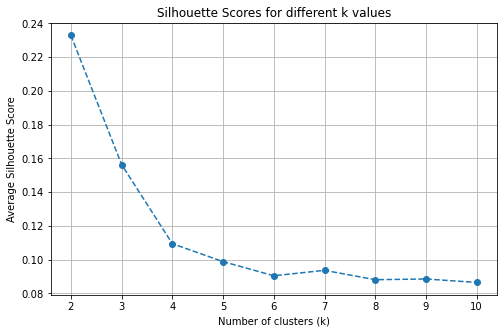

In [12]:
silhouette_scores = []
# Test k values from 2 to 10 (Silhouette Score requires at least 2 clusters)
k_range_sil = range(2, 11)

for i in k_range_sil:
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    cluster_labels = kmeans.fit_predict(final_data)
    score = silhouette_score(final_data, cluster_labels)
    silhouette_scores.append(score)
    print(f"k={i}: Silhouette Score = {score:.4f}")

# Plotting the Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(k_range_sil, silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Scores for different k values')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Average Silhouette Score')
plt.xticks(k_range_sil)
plt.grid(True)
plt.show()

## Analysis based on  Silhouette Score

The Silhouette Score measures how similar a data point is to its own cluster compared to other clusters. The score ranges from -1 to 1.
Near +1: The sample is well-clustered.
Near 0: The sample is on the boundary between two clusters.
Near -1: The sample has been assigned to the wrong cluster.

So in this case building 2 clusters is optimum.

In [13]:
# Final K-Means Clustering with optimal k=4
optimal_k = 2

kmeans_final = KMeans(n_clusters=optimal_k, init='k-means++', max_iter=300, n_init=10, random_state=42)
y_kmeans = kmeans_final.fit_predict(final_data)
centers = kmeans_final.cluster_centers_
print("centers\n",centers)

# Performance Metrics for the Final Model
print("\n--- Final Model Performance (k=2) ---")


# Final optimum Silhouette Score
final_silhouette = silhouette_score(final_data, y_kmeans)
print(f"Silhouette Score: {final_silhouette:.4f}")

centers
 [[0.502      0.514      0.522      0.772      0.483      0.514
  2.5        0.53650768 0.41004    0.23194737 0.49109677 0.44044444
  0.499725   0.51314286 0.5042     0.35130918 0.53534179 0.7375799
  0.52464286 0.32894444 0.50194444]
 [0.488      0.505      0.521      0.751      0.523      0.5
  0.5        0.44882098 0.40776    0.22168421 0.47814516 0.45233333
  0.504425   0.49271429 0.48745    0.30696429 0.46801669 0.26093052
  0.51914286 0.31183333 0.49927778]]

--- Final Model Performance (k=2) ---
Silhouette Score: 0.2330


## Final Analysis
Based on the analysis above two clusters are optimum having specific coordinates. Any new data will be in a luster, from which(corresponding centroid) it is closest.